In [1]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [9]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'Na':0.075, 'Cl':0.056}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Halite"],
                           kreaction="inf")
builder.make_grid(10, 5)
builder.set_species()

In [10]:
builder.set_initial_guess_from_bulk()

In [11]:
sol = builder.solve_gem_lagrangian(method='hybr')

In [12]:
sol.fun

array([-1.04196774e-04,  2.25894740e-05,  2.49983311e-05, -2.00885702e-06,
        1.23343657e-05,  4.54570571e-06, -2.79642404e-06, -1.95725266e-06,
       -1.76004446e-06, -8.01065231e-09, -4.56173958e-08,  2.26507004e-05,
        5.69938568e-08,  8.38907617e-04,  6.88240204e-05, -2.47389633e-06,
       -9.38568936e-06,  1.94220234e-05,  1.00228587e-03,  5.94737550e-05,
       -4.90359928e-05, -5.53583170e-05,  4.53873120e-05,  6.30999835e-06,
       -1.29886339e-05, -7.24465281e-07,  2.34743084e-07, -3.02680870e-06,
       -4.20479258e-06, -1.65679387e-06, -5.24403027e-04,  3.31799979e-05,
       -4.73921730e-04,  6.16889850e-04,  9.28726990e-05, -3.71810259e-06,
       -1.84486052e-06,  1.79995668e-05,  2.87631846e-05,  4.47973180e-05,
        4.84368002e-06, -2.51852796e-05, -7.09679042e-03,  3.76027964e-04,
        2.60304689e-05,  1.35300251e-03,  6.21794899e-05, -4.90536229e-06,
       -6.09338207e-06, -8.79057417e-06, -1.95503235e-05,  9.57489014e-04,
        9.42230225e-04,  

In [145]:
#min f(x)
#s.t. g(x) = 0
#-------------
#grad f(x) - jac(g)(x)^T \lambda = 0
#g(x) = 0
#h(x, \lambda) = [grad f(x) - jac(g)(x)^T \lambda, g(x)]
#dh(x, \lambd) = [[hess f(x) - -d/dx(jac(g)(x)^T), -jac(g)(x)^T], [jac(g)(x), 0]

In [154]:
logcmu = builder.x.reshape(builder.nspecies, builder.ngrid).numpy()
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

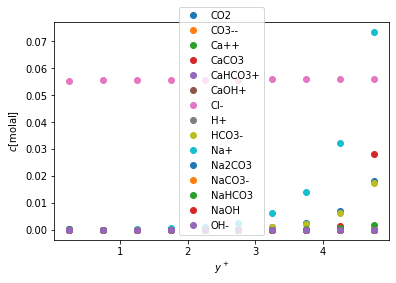

In [159]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

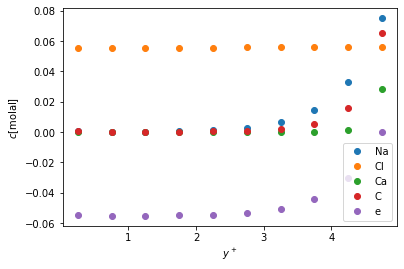

In [148]:
cel = builder.reduced_formula_matrix.numpy()@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

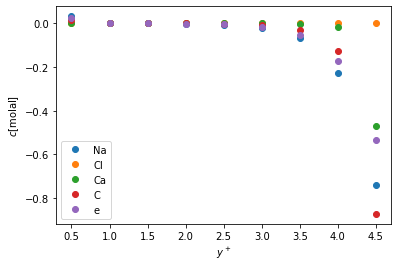

In [156]:
fluxes = builder.fluxes().detach().numpy()
yplot = builder.ypoints[1:-1].detach().numpy()
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(yplot, fluxes[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [124]:
builder.full_residual()

AttributeError: 'TransportBuilder' object has no attribute 'logc'